In [45]:

import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

import numpy as np
from sklearn.utils import resample
import random
# Import necessary libraries
from keras.datasets import cifar10

In [46]:
import datetime
import os
import json
from datetime import datetime

config = {
    'currentModel' : 'ENSEMBLE',
    'training' : True,
    'overFit' : False,
    'heldOutClasses' : False,
    'epochs' : 30,
    'patience' : 10,
    'saveModel' : True,
    'seed': 0,
    'batchSize' : 32
}

config['ensembleSize'] = 20 if 'ENSEMBLE' in config['currentModel'] else 1
config['startEpochs'] = 20 if 'overFit' in config['currentModel'] else 1


In [47]:
# Here we want to load every config.json file in the ./models/** folder and create a dataframe with all the results

import glob
import json
import pandas as pd

# Path to search for 'config.json' files
path = './models/**/config.json'

# Find all matching files
files = glob.glob(path, recursive=True)
data = []
for file in files:
    with open(file, 'r') as f:
        content = json.load(f)
        content['path'] = file
        data.append(content)
df_test = pd.DataFrame(data)


matching_conditions = [
    ('currentModel', 'ENSEMBLE'),
    ('heldOutClasses', False),
]

for condition in matching_conditions:
    df_test = df_test[df_test[condition[0]] == condition[1]]

# Display the DataFrame
print(df_test)


  currentModel  training  overFit  heldOutClasses  epochs  patience  \
3     ENSEMBLE      True    False           False      20        10   
5     ENSEMBLE      True    False           False       3         5   
6     ENSEMBLE      True    False           False      30        10   

   saveModel  seed  ensembleSize  startEpochs     dateRun  batchSize  \
3       True     0            20            1  2024-04-25          1   
5       True     0             3            1  2024-04-30         32   
6       True     0            20            1  2024-04-30         32   

                                path  
3  ./models/2024-04-25/0/config.json  
5  ./models/2024-04-30/0/config.json  
6  ./models/2024-04-30/1/config.json  


In [48]:

LOAD_MODEL_LOCATION =  './models/2024-04-30/1/'


In [49]:

if LOAD_MODEL_LOCATION:
    config = json.load(open(f'{LOAD_MODEL_LOCATION}/config.json'))
    config['training'] = False
    config['saveModel'] = False
    MODEL_FILE = f'{LOAD_MODEL_LOCATION}'
    print(config)
else:
    # Formatted as 'YYYY-MM-DD'
    today = datetime.today().strftime('%Y-%m-%d')
    config['dateRun'] = today
    # Get all the directories in the models folder
    os.makedirs(f'./models/{today}', exist_ok=True)
    dirs = os.listdir(f'./models/{today}')
    dir_name = max([int(d) for d in dirs]) + 1 if dirs else 0

    MODEL_FILE = f'./models/{today}/' + str(dir_name)

    os.makedirs(f'{MODEL_FILE}', exist_ok=True)

    with open(f'{MODEL_FILE}/config.json', 'w+') as f:
        # write json to file as double quoted and formatted
        json.dump(config, f, indent=4)


np.random.seed(config['seed'])
# set random seed for tf
tf.random.set_seed(config['seed'])
# random seed for python built-in random module
random.seed(config['seed'])

print(f"Model file: {MODEL_FILE}")

{'currentModel': 'ENSEMBLE', 'training': False, 'overFit': False, 'heldOutClasses': False, 'epochs': 30, 'patience': 10, 'saveModel': False, 'seed': 0, 'batchSize': 32, 'ensembleSize': 20, 'startEpochs': 1, 'dateRun': '2024-04-30'}
Model file: ./models/2024-04-30/1/


In [50]:
from sklearn.model_selection import train_test_split

dataset = cifar10.load_data()

# Turn it into a binary classification problem by making it frogs or not frogs
(train_images, train_labels), (test_images, test_labels) = dataset

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0
# Load the dataset
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

# Separate frog and not frog images
frog_indices = np.where(train_labels == 6)[0]
not_frog_indices = np.where(train_labels != 6)[0]

if config['heldOutClasses']:
    config['heldOutClasses'] = [0, 1]
else:
    config['heldOutClasses'] = []

held_out_class_indices_train = np.where(np.isin(train_labels, config['heldOutClasses']))[0]    
held_out_class_indices_test = np.where(np.isin(test_labels, config['heldOutClasses']))[0]    

not_frog_indices = np.setdiff1d(not_frog_indices, held_out_class_indices_train)

# Downsample majority (not frog)
not_frog_downsampled = resample(not_frog_indices,
                                replace=False, # sample without replacement
                                n_samples=len(frog_indices), # match minority n
                                random_state=27) # reproducible results

# Combine minority and downsampled majority
downsampled_indices = np.concatenate([frog_indices, not_frog_downsampled])

# Downsampled feature and label sets
train_labels = np.where(train_labels == 6, 1, 0)
test_labels = np.where(test_labels == 6, 1, 0)

train_images = train_images[downsampled_indices]
train_labels = train_labels[downsampled_indices]

test_images_held_out = test_images[held_out_class_indices_test]
test_labels_held_out = test_labels[held_out_class_indices_test]

test_images = np.delete(test_images, held_out_class_indices_test, axis=0)
test_labels = np.delete(test_labels, held_out_class_indices_test, axis=0)

# Create a new test set with corrupted data
# apply gaussian blur to the images

from scipy.ndimage import gaussian_filter
import copy

def corrupt_images(images, sigma=1):
    return gaussian_filter(images, sigma=sigma)


# Split the training set into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=config['seed'])

corrupted_test_images = corrupt_images(test_images, sigma=1)
corrupted_test_labels = copy.deepcopy(test_labels)

corrupted_held_out_images = corrupt_images(test_images_held_out, sigma=1)
corrupted_held_out_labels = copy.deepcopy(test_labels_held_out)

corrupted_val_images = corrupt_images(val_images, sigma=1)
corrupted_val_labels = copy.deepcopy(val_labels)








In [51]:

# import tensorflow as tf
# import tensorflow_datasets as tfds

# def extract_images_and_labels(corruption='gaussian_blur_5'):
#     test_data, ds_info = tfds.load(
#         f'cifar10_corrupted/{corruption}',
#         split='test',
#         as_supervised=True,
#         with_info=True,
#         shuffle_files=True
#     )
#     images = []
#     labels = []
#     for image, label in tfds.as_numpy(test_data):
#         images.append(image)
#         labels.append(label)
#     return np.array(images), np.array(labels)

# corrupted_test_images, corrupted_test_labels = extract_images_and_labels()

# corrupted_test_labels = np.where(corrupted_test_labels == 6, 1, 0).reshape(-1, 1)


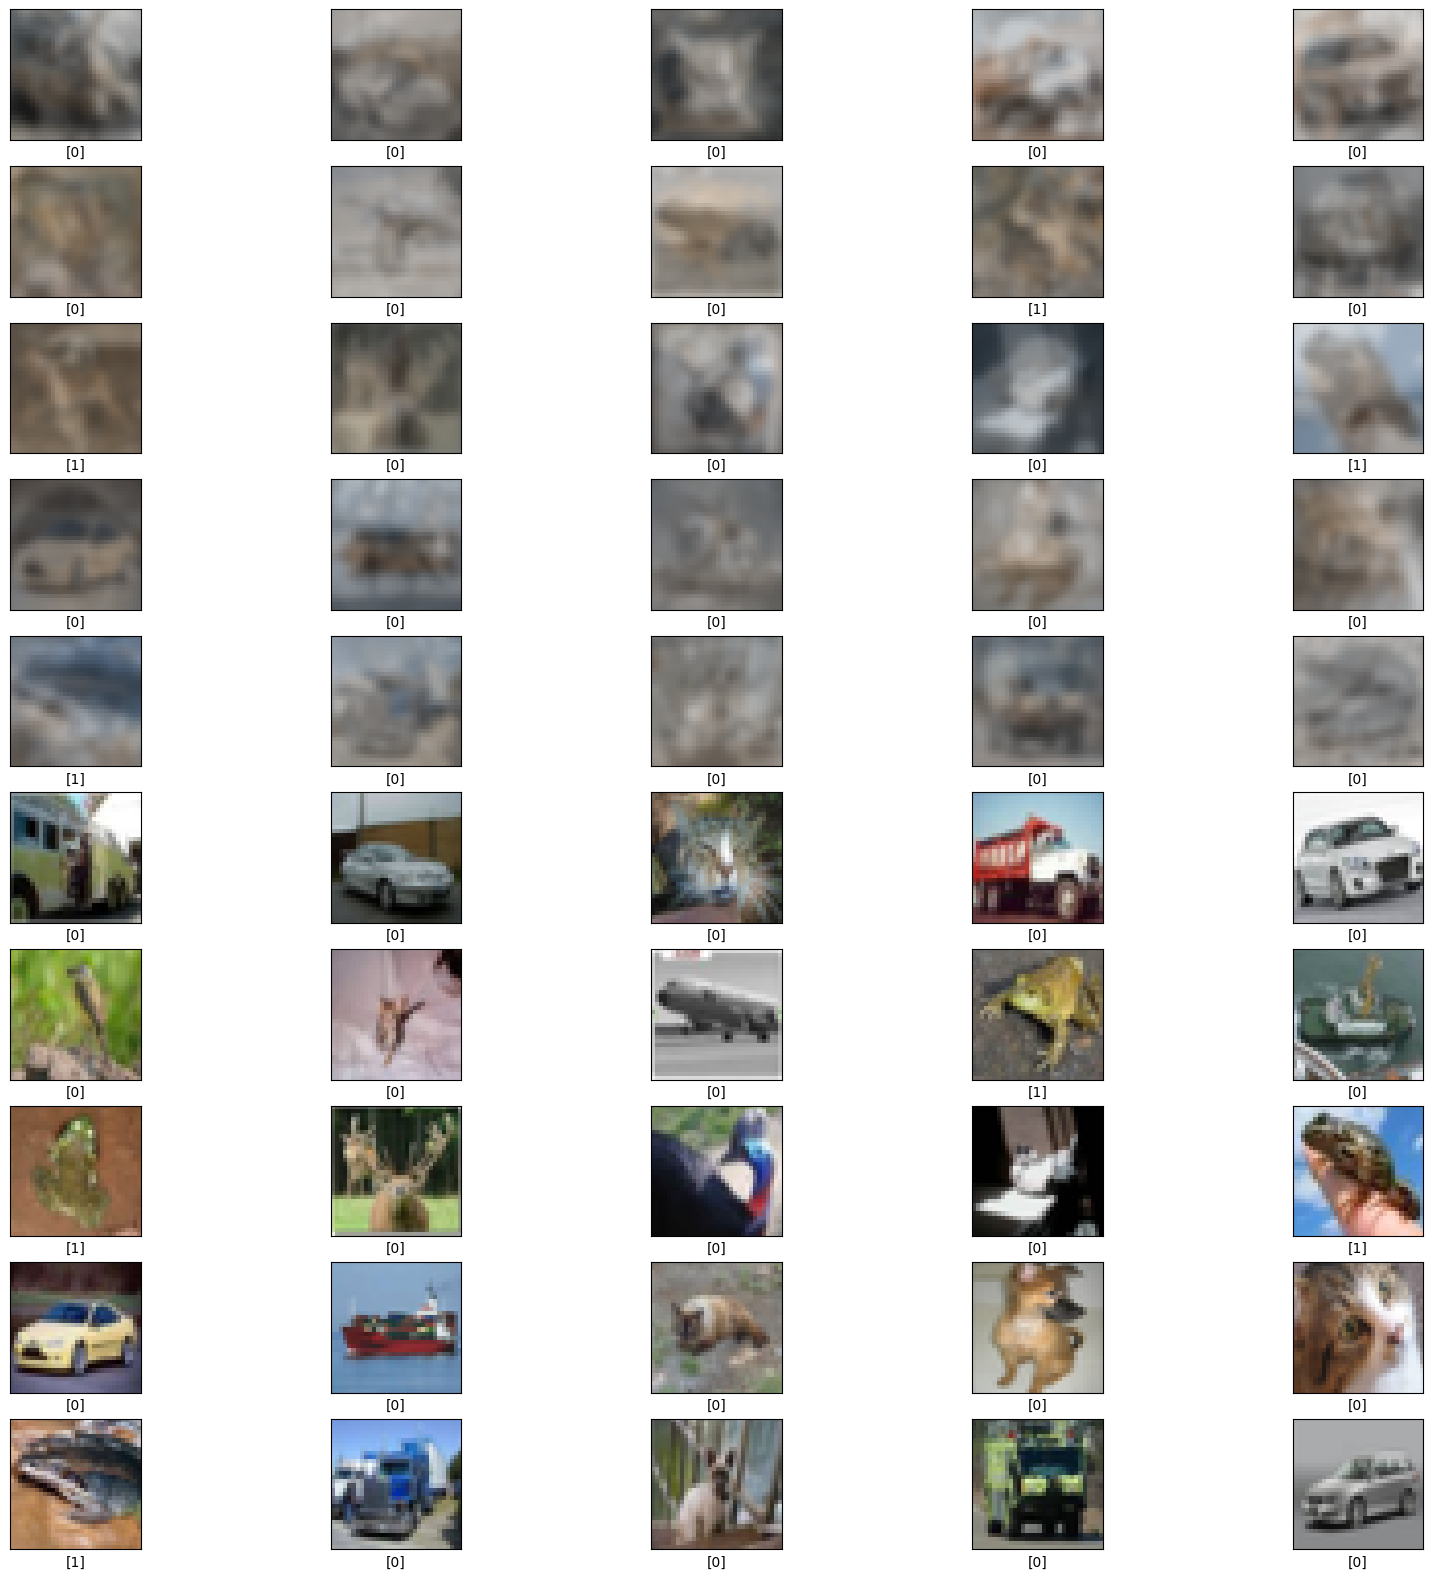

In [52]:
if True:
    class_names = ['not_frog', 'frog']

    randomly_chosen_indexes = np.random.uniform(0, len(corrupted_test_images), 25).astype(int)
    plt.figure(figsize=(20,20))
    for i, value in enumerate(randomly_chosen_indexes):
        plt.subplot(10,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(corrupted_test_images[value])
        # plt.imshow(test_images[value])
        plt.xlabel(corrupted_test_labels[value])


        plt.subplot(10,5,i + 25 +1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(test_images[value])
        # plt.imshow(test_images[value])
        plt.xlabel(test_labels[value])
    plt.show()

### Compile and train the model

In [53]:

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint



history_list = {}

history_dict_base = {
    'accuracy': [],
    'val_accuracy': [],
    'loss': [],
    'val_loss': []
}

history_dict = {}


for i in range(config['ensembleSize']): 
    history_dict[i] = {
    'accuracy': [],
    'val_accuracy': [],
    'loss': [],
    'val_loss': []
    }

    history_list[i] = []

print(history_dict)



{0: {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}, 1: {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}, 2: {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}, 3: {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}, 4: {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}, 5: {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}, 6: {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}, 7: {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}, 8: {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}, 9: {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}, 10: {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}, 11: {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}, 12: {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}, 13: {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}, 14: {'accuracy': [], 'val_acc

In [54]:
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import Input, Layer
from tensorflow.keras.models import Model

# Function to set dropout rate
def set_dropout_rate(model, new_rate):
    for layer in model.layers:
        if isinstance(layer, Dropout):
            layer.rate = new_rate


def create_dropout_model(dropout_rate=0.5):
    # Input layer
    inputs = Input(shape=(32, 32, 3))

    # Convolutional and MaxPooling layers
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)

    # Flatten layer
    x = Flatten()(x)

    # Dense layers with dropout
    x = Dropout(dropout_rate)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(16, activation='relu')(x)

    # Output layer
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    # Create model
    model = Model(inputs=inputs, outputs=outputs)

    return model
  

In [55]:
 
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Input
from tensorflow.keras.models import Model

def create_model():
    # Input layer
    inputs = Input(shape=(32, 32, 3))

    # Convolutional and MaxPooling layers
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)

    # Flatten layer
    x = Flatten()(x)

    # Dense layers with dropout
    x = Dense(64, activation='relu')(x)
    x = Dense(16, activation='relu')(x)

    # Output layer
    outputs = Dense(1, activation='sigmoid')(x)

    # Create model
    model = Model(inputs=inputs, outputs=outputs)

    return model

In [56]:
from tensorflow.keras.callbacks import TensorBoard

if config['training']:

    for i in range(config['ensembleSize']):

        # Define the early stopping callback
        early_stopping = EarlyStopping(monitor='val_auc', patience=config['patience'], start_from_epoch=config['startEpochs'], restore_best_weights=True, mode='max')

        log_dir = f"{MODEL_FILE}/tenserboard/{i}"
        tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
        # Define the model checkpoint callback
        model_checkpoint = ModelCheckpoint(f'{MODEL_FILE}/{i}.keras', monitor='val_auc', save_best_only=True, mode='max', overwrite=False)

        callbacks = [early_stopping, tensorboard_callback]

        if config['saveModel']:
            callbacks.append(model_checkpoint)


        model = create_dropout_model() if config['currentModel'] == 'BNN' else create_model()
        
        model.compile(optimizer='adam',
                    loss=tf.keras.losses.BinaryCrossentropy(),
                    metrics=['accuracy', tf.keras.metrics.AUC(name='auc', curve='ROC')])

        set_dropout_rate(model, np.nextafter(np.float32(0), np.float32(1))) if config['currentModel'] == 'BNN' else ''

        X_train_subset, y_train_subset = resample(train_images, train_labels)

        history = model.fit(X_train_subset, y_train_subset, epochs=config['epochs'],
                            validation_data=(val_images, val_labels),
                            callbacks=[early_stopping, model_checkpoint], batch_size=config['batchSize'])

        set_dropout_rate(model, 0.5) if config['currentModel'] == 'BNN' else ''

        history_list[i].append(history)

        for history in history_list[i]:
            for key in history_dict_base.keys():
                history_dict[i][key].extend(history.history[key])


In [57]:
if config['currentModel'] == 'BNN':
    import numpy as np
    from tensorflow.keras.models import load_model

    class MCDropoutModel():
        def __init__(self, base_model, num_predictions=100, dropout_rate=0.5):
            self.base_model = base_model
            self.num_predictions = num_predictions
            self.dropout_rate = dropout_rate

        def verbose_predict(self, inputs):
            outputs = []
            set_dropout_rate(self.base_model, self.dropout_rate)
            for _ in range(self.num_predictions):
                # Enable dropout during prediction
                outputs.append(self.base_model(inputs, training=True))

            outputs_stack = tf.stack(outputs, axis=0)

            return outputs_stack
        
        

    loaded_model = load_model(f'{MODEL_FILE}/0.keras')

    # Wrap the base model with the MCDropoutModel
    model_under_test = MCDropoutModel(loaded_model, num_predictions=20)


In [58]:

# set_dropout_rate(loaded_model, 0.5)
# model_with_two_predictions = MCDropoutModel(loaded_model, num_predictions=2)

# predictions = model_with_two_predictions.verbose_predict(test_images[:4])

In [59]:
if config['currentModel'] == 'ENSEMBLE':
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Input, Average
    from tensorflow.keras.models import load_model


    class EnsembleModel:
        def __init__(self, models, **kwargs):
            super(EnsembleModel, self).__init__(**kwargs)
            self.models = models

        def verbose_predict(self, inputs):
            # Forward pass through each model
            outputs = [model(inputs) for model in self.models]

            # Stack all model outputs
            outputs_stack = tf.stack(outputs, axis=0)

            return outputs_stack


    model_list = []

    for i in range(config['ensembleSize']): 
        ensemble_member = load_model(f'{MODEL_FILE}/{i}.keras')
        ensemble_member.evaluate(test_images, test_labels)
        model_list.append(ensemble_member)


    # Create the ensemble model
    model_under_test = EnsembleModel(model_list)

    

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7990 - auc: 0.9179 - loss: 0.4049
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7696 - auc: 0.9115 - loss: 0.4803
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8132 - auc: 0.9037 - loss: 0.3711
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7379 - auc: 0.8967 - loss: 0.5117
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8331 - auc: 0.9030 - loss: 0.3426
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8770 - auc: 0.9030 - loss: 0.3000
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7849 - auc: 0.9144 - loss: 0.4307
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7796 - auc: 0.9089 - loss: 0.4425
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8619 - auc: 0.8978 - loss: 0.3123
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6794 - auc: 0.8930 - loss: 0.6307
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5032 - auc: 0.8967 - loss: 0.7975
313/313 ━━━━━━━━━━━━━

In [60]:
import pandas as pd
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np


def produce_df_from_predictions(model_under_test, test_images, test_labels):
    print(test_images.shape, test_labels.shape)
    outputs_stack = model_under_test.verbose_predict(test_images)
    outputs_mean = np.mean(outputs_stack, axis=0)
    outputs_variance = np.var(outputs_stack, axis=0)
    ensemble_predictions = np.where(outputs_mean > 0.5, 1, 0)
    individual_outputs = np.array(outputs_stack).squeeze().T.tolist()
    output_confidence = np.abs(outputs_mean - 0.5)
    prediction_outcome = np.where(ensemble_predictions != test_labels, 0, 1)
    # make sure all the arrays are the n x 1 shape
    np_df = np.hstack((output_confidence, outputs_variance, prediction_outcome, outputs_mean, test_labels, ensemble_predictions))
    df = pd.DataFrame(np_df, columns=['confidence', 'variance', 'outcome', 'mean', 'label', 'prediction'])
    df['individual_predictions'] = individual_outputs
    print(df.head())
    df['tp'] = df.apply(lambda row: int(row['label'] == 1 and row['prediction'] == 1), axis=1)
    df['fp'] = df.apply(lambda row: int(row['label'] == 0 and row['prediction'] == 1), axis=1)
    df['tn'] = df.apply(lambda row: int(row['label'] == 0 and row['prediction'] == 0), axis=1)
    df['fn'] = df.apply(lambda row: int(row['label'] == 1 and row['prediction'] == 0), axis=1)

    df.head()

    return df

df_test = produce_df_from_predictions(model_under_test, test_images, test_labels)

df_val = produce_df_from_predictions(model_under_test, val_images, val_labels)

df_train = produce_df_from_predictions(model_under_test, train_images, train_labels)

df_held_out = produce_df_from_predictions(model_under_test, test_images_held_out, test_labels_held_out)

df_corrupted = produce_df_from_predictions(model_under_test, corrupted_test_images, corrupted_test_labels)

df_val_corrupted = produce_df_from_predictions(model_under_test, corrupted_val_images, corrupted_val_labels)

plt.show()


(10000, 32, 32, 3) (10000, 1)
   confidence  variance  outcome      mean  label  prediction  \
0    0.166574  0.017921      0.0  0.666574    0.0         1.0   
1    0.432443  0.009686      1.0  0.067557    0.0         0.0   
2    0.440459  0.002415      1.0  0.059541    0.0         0.0   
3    0.390368  0.009638      1.0  0.109632    0.0         0.0   
4    0.245863  0.006099      1.0  0.745863    1.0         1.0   

                              individual_predictions  
0  [0.6973044276237488, 0.6903527975082397, 0.625...  
1  [0.02986431121826172, 0.041583385318517685, 0....  
2  [0.04662694036960602, 0.044530607759952545, 0....  
3  [0.0678630843758583, 0.08754917979240417, 0.07...  
4  [0.7047227025032043, 0.8176847696304321, 0.770...  
(2000, 32, 32, 3) (2000, 1)
   confidence  variance  outcome      mean  label  prediction  \
0    0.383309  0.016196      1.0  0.116691    0.0         0.0   
1    0.159941  0.019828      1.0  0.659941    1.0         1.0   
2    0.112435  0.023798   


purple yellow purple yellow
blue black grey black


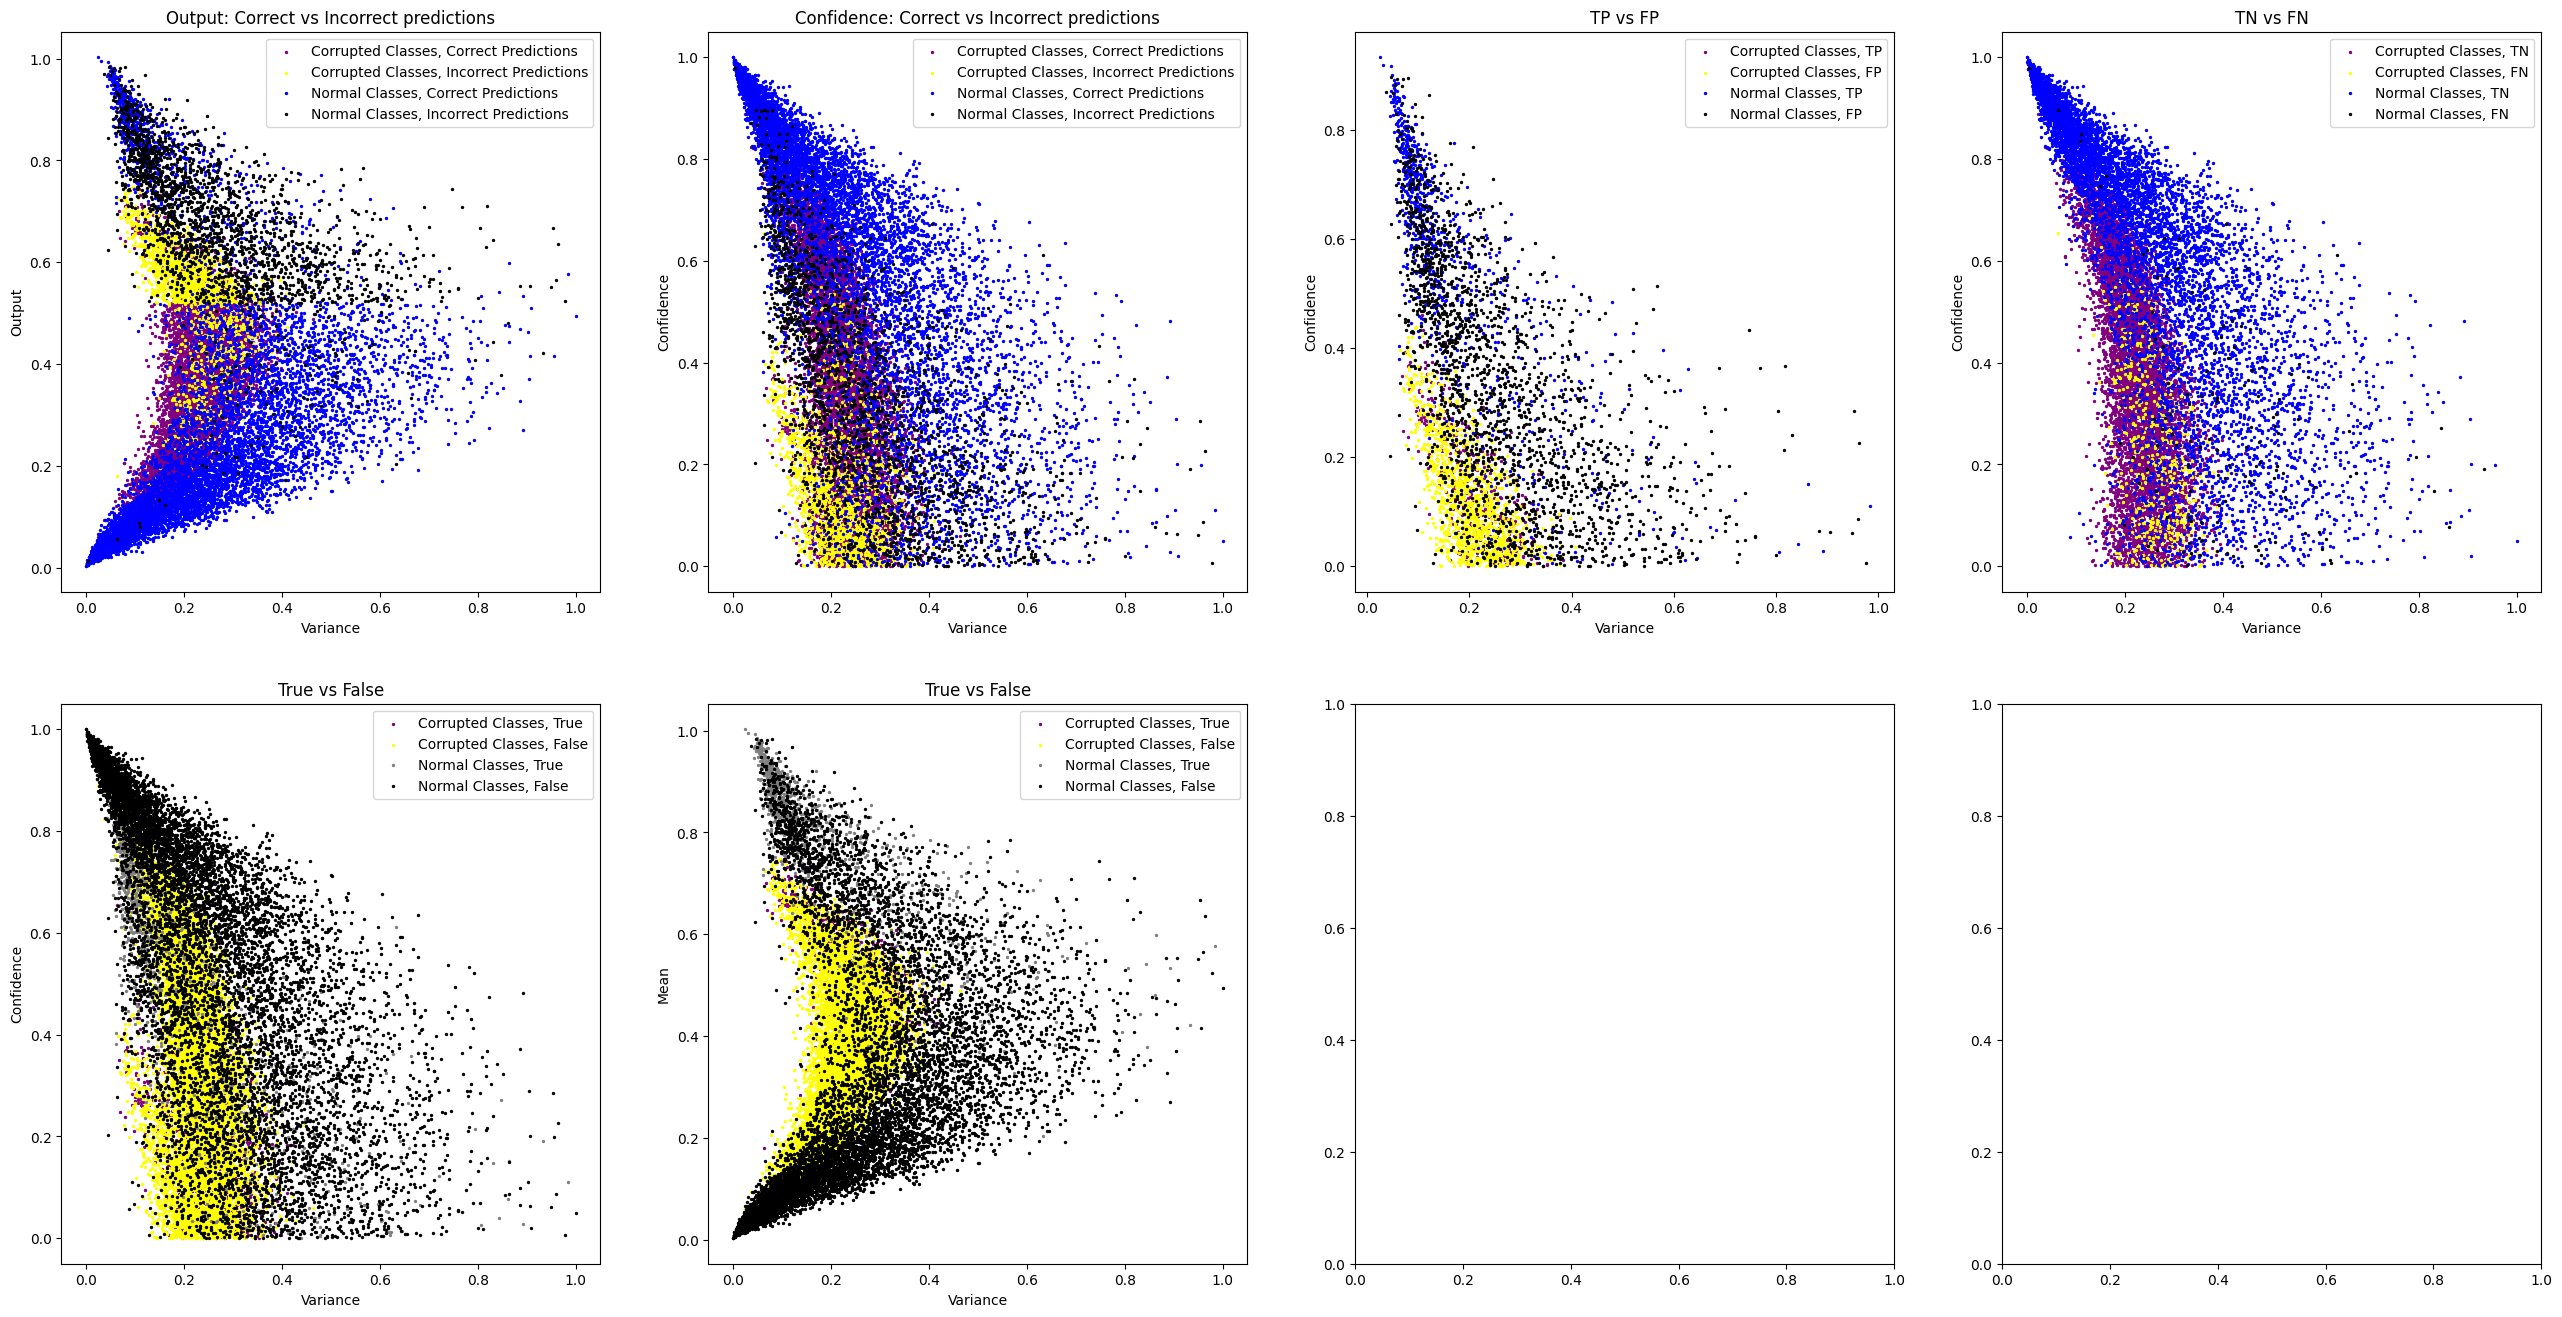

In [61]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf

def normalize_and_plot(x, y, color, label=None, axs=None, plot_quantile=False):
    """Normalize and plot the given data."""
    # Convert to numpy for plotting

    # Normalize x and y
    # x_numpy_normalized = (x - x.min()) / (x.max() - x.min())
    # y_numpy_normalized = (y - y.min()) / (y.max() - y.min())

    # Plotting
    axs.scatter(x, y, color=color, label=label, s=2)
    if x.shape[0] > 0 and y.shape[0] > 0 and plot_quantile:

        # Prepare data for quantile regression
        df = pd.DataFrame({'x': x, 'y': y})

        # Fit a quantile regression model
        mod = smf.quantreg('y ~ x', df)
        res1 = mod.fit(q=0.5)
        res2 = mod.fit(q=0.95)

        # Get the fitted values
        y_pred1 = res1.predict(df['x'])
        y_pred2 = res2.predict(df['x'])

        # Plot the quantile regression line
        axs.plot(x, y_pred1, color=color, linewidth=2)
        axs.plot(x, y_pred2, color=color, linewidth=2)

print()

def plot_confidence_vs_variance_findings(dataframe_names, dataframes, plot_correctness=['correct', 'incorrect'], plot_quantile=False):

    # We want to get the max and min of the variance, mean and confidence values accross all dataframes
    # This is so we can normalize the values and plot them on the same scale
    max_variance = max([df['variance'].max() for df in dataframes.values()])
    min_variance = min([df['variance'].min() for df in dataframes.values()])
    max_mean = max([df['mean'].max() for df in dataframes.values()])
    min_mean = min([df['mean'].min() for df in dataframes.values()])
    max_confidence = max([df['confidence'].max() for df in dataframes.values()])
    min_confidence = min([df['confidence'].min() for df in dataframes.values()])

    fig, axs = plt.subplots(2, 4, figsize=(32, 16))

    for i, name in enumerate(dataframe_names):

        if name == 'normal':
            colour_correct = 'blue'
            colour_false = 'red'
            colour_true = 'grey'
            colour_false = 'black'
            label = 'Normal Classes'
            df = dataframes['normal']
        elif name == 'held_out':
            colour_correct = 'green'
            colour_false = 'orange'
            colour_true = 'green'
            colour_false = 'red'
            label = 'Held Out Classes'
            df = dataframes['held_out']
        elif name == 'corrupted':
            colour_correct = 'purple'
            colour_false = 'yellow'
            colour_true = 'purple'
            colour_false = 'yellow'
            label = 'Corrupted Classes'
            df = dataframes['corrupted']


        df['mean_normalized'] = (df['mean'] - min_confidence) / (max_mean - min_mean)
        df['variance_normalized'] = (df['variance'] - min_variance) / (max_variance - min_variance)
        df['confidence_normalized'] = (df['confidence'] - min_confidence) / (max_confidence - min_confidence)

        var_correct = df[df['outcome'] == 1]['variance_normalized'].to_numpy()
        var_incorrect = df[df['outcome'] == 0]['variance_normalized'].to_numpy()
        output_correct = df[df['outcome'] == 1]['mean_normalized'].to_numpy()
        output_incorrect = df[df['outcome'] == 0]['mean_normalized'].to_numpy()
        conf_correct = df[df['outcome'] == 1]['confidence_normalized'].to_numpy()
        conf_incorrect = df[df['outcome'] == 0]['confidence_normalized'].to_numpy()
        var_tp = df[df['tp'] == 1]['variance_normalized'].to_numpy()
        conf_tp = df[df['tp'] == 1]['confidence_normalized'].to_numpy()
        var_fp = df[df['fp'] == 1]['variance_normalized'].to_numpy()
        conf_fp = df[df['fp'] == 1]['confidence_normalized'].to_numpy()
        var_tn = df[df['tn'] == 1]['variance_normalized'].to_numpy()
        conf_tn = df[df['tn'] == 1]['confidence_normalized'].to_numpy()
        var_fn = df[df['fn'] == 1]['variance_normalized'].to_numpy()
        conf_fn = df[df['fn'] == 1]['confidence_normalized'].to_numpy()

        var_true = df[df['label'] == 1]['variance_normalized'].to_numpy()
        conf_true = df[df['label'] == 1]['confidence_normalized'].to_numpy()
        mean_true = df[df['label'] == 1]['mean_normalized'].to_numpy()
        var_false = df[df['label'] == 0]['variance_normalized'].to_numpy()
        conf_false = df[df['label'] == 0]['confidence_normalized'].to_numpy()
        mean_false = df[df['label'] == 0]['mean_normalized'].to_numpy()

        print(colour_correct, colour_false, colour_true, colour_false)
        if 'correct' in plot_correctness:
            normalize_and_plot(var_correct, output_correct, colour_correct, f'{label}, Correct Predictions', axs[0][0])
        if 'incorrect' in plot_correctness:
            normalize_and_plot(var_incorrect, output_incorrect, colour_false, f'{label}, Incorrect Predictions', axs[0][0])
        # Add labels and legend
        axs[0][0].set_title(f'Output: Correct vs Incorrect predictions')
        axs[0][0].set_xlabel('Variance')
        axs[0][0].set_ylabel('Output')
        axs[0][0].legend()

        if 'correct' in plot_correctness:
            normalize_and_plot(var_correct, conf_correct, colour_correct, f'{label}, Correct Predictions', axs[0][1])
        if 'incorrect' in plot_correctness:
            normalize_and_plot(var_incorrect, conf_incorrect, colour_false, f'{label}, Incorrect Predictions', axs[0][1])
        # Add labels and legend
        axs[0][1].set_title(f'Confidence: Correct vs Incorrect predictions')
        axs[0][1].set_xlabel('Variance')
        axs[0][1].set_ylabel('Confidence')
        axs[0][1].legend()

        if 'correct' in plot_correctness:
            normalize_and_plot(var_tp, conf_tp, colour_correct, f'{label}, TP', axs[0][2])
        if 'incorrect' in plot_correctness:
            normalize_and_plot(var_fp, conf_fp, colour_false, f'{label}, FP', axs[0][2])
        axs[0][2].set_title(f'TP vs FP')
        axs[0][2].set_xlabel('Variance')
        axs[0][2].set_ylabel('Confidence')
        axs[0][2].legend()

        if 'correct' in plot_correctness:
            normalize_and_plot(var_tn, conf_tn, colour_correct, f'{label}, TN', axs[0][3])
        if 'incorrect' in plot_correctness:
            normalize_and_plot(var_fn, conf_fn, colour_false, f'{label}, FN', axs[0][3])
        axs[0][3].set_title(f'TN vs FN')
        axs[0][3].set_xlabel(f'Variance')
        axs[0][3].set_ylabel(f'Confidence')
        axs[0][3].legend()

        # plot class 0 vs class 1 plots
        normalize_and_plot(var_true, conf_true, colour_true, f'{label}, True', axs[1][0])
        normalize_and_plot(var_false, conf_false, colour_false, f'{label}, False', axs[1][0])
        axs[1][0].set_title(f'True vs False')
        axs[1][0].set_xlabel(f'Variance')
        axs[1][0].set_ylabel(f'Confidence')
        axs[1][0].legend()

        normalize_and_plot(var_true, mean_true, colour_true, f'{label}, True', axs[1][1])
        normalize_and_plot(var_false, mean_false, colour_false, f'{label}, False', axs[1][1])
        axs[1][1].set_title(f'True vs False')
        axs[1][1].set_xlabel(f'Variance')
        axs[1][1].set_ylabel(f'Mean')
        axs[1][1].legend()






plot_confidence_vs_variance_findings(['corrupted', 'normal'], {'normal': df_test, 'held_out': df_held_out, 'corrupted': df_corrupted}, ['correct', 'incorrect'])

# Display the plot
plt.show()

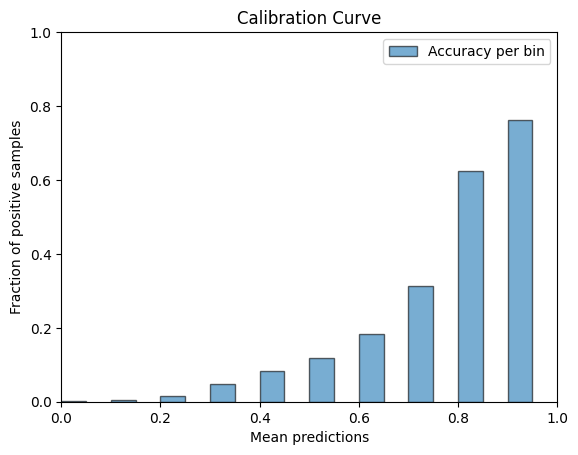

,title,auc,accuracy,precision,recall,f1_score,ece
0,df_test,0.906313,0.789,0.304164,0.862,0.449661,0.235944


In [62]:
from sklearn.metrics import confusion_matrix
# Get the AUC
from sklearn.metrics import roc_auc_score
# display the confusion matrix
import seaborn as sns

from sklearn.metrics import roc_curve

def calculate_ece(labels, predictions, n_bins=10):
    bins = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bins[:-1]
    bin_uppers = bins[1:]

    ece = 0.0
    bin_proportion_of_class_1 = []
    bin_mean_confidences = []
    bin_counts = []

    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # Find indices of predictions that fall into the current bin
        in_bin = np.where((predictions > bin_lower) & (predictions <= bin_upper))[0]
        if len(in_bin) > 0:
            # True labels and predicted probabilities in the bin
            bin_labels = labels[in_bin]
            bin_predictions = predictions[in_bin]
            
            # Accuracy and confidence in the bin
            proportion_of_class_1 = np.mean(bin_labels)
            mean_predictions = np.mean(bin_predictions)

            # debug
            # print(f'Bin: {bin_lower} - {bin_upper}')
            # print(f'Proportion of class 1: {proportion_of_class_1}')
            # print(f'Mean predictions: {mean_predictions}')
            # print(f'Number of samples in bin: {len(in_bin)}')
        

            
            # ECE contribution from this bin, weighted by the number of samples in the bin
            ece += np.abs(proportion_of_class_1 - mean_predictions) * len(in_bin) / len(predictions)

            # Save results for plotting
            bin_proportion_of_class_1.append(proportion_of_class_1)
            bin_mean_confidences.append(mean_predictions)
            bin_counts.append(len(in_bin))
        else:
            bin_proportion_of_class_1.append(0)
            bin_mean_confidences.append(0)
            bin_counts.append(0)

    # print("ECE:", ece)

    # Plotting
    plt.bar(bin_lowers, bin_proportion_of_class_1, width=1/20, align='edge', edgecolor='black', alpha=0.6, label='Accuracy per bin')
    # plt.plot(bin_lowers, bin_mean_confidences, marker='o', color='red', linestyle='--', label='Confidence per bin')
    plt.xlabel('Mean predictions')
    plt.ylabel('Fraction of positive samples')
    # x is between 0 and 1
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.title('Calibration Curve')
    plt.legend()
    plt.show()

    return ece


def evaluation_report(df, title='No Title passed in'):
    # print(f'\n\nEvaluation: {title}\n\n')
    if df.empty:
        # print("No data to evaluate")
        return
    
    tp_count = df['tp'].sum()
    tn_count = df['tn'].sum()
    fp_count = df['fp'].sum()
    fn_count = df['fn'].sum()


    accuracy = ( tp_count + tn_count ) / ( tp_count + tn_count + fp_count + fn_count )

    precision = tp_count / ( tp_count + fp_count )

    recall = tp_count / ( tp_count + fn_count )

    f1_score = 2 * ( ( precision * recall ) / ( precision + recall ) )

    auc = roc_auc_score(df['label'], df['mean'])

    ece = calculate_ece(df['label'], df['mean'])

    result_df = pd.DataFrame({
        'title': [title],
        'auc': [auc],
        'accuracy': [accuracy],
        'precision': [precision],
        'recall': [recall],
        'f1_score': [f1_score],
        'ece': [ece]
    })

    return result_df



evaluation_report(df_test, 'df_test')
# evaluation_report(df_held_out, 'df_held_out')
# evaluation_report(df_corrupted, 'df_corrupted')

In [63]:

true_positive_indices = df_test[df_test['tp'] == 1].sort_values('confidence', ascending=False).index.to_numpy()
false_positive_indices = df_test[df_test['fp'] == 1].sort_values('confidence', ascending=False).index.to_numpy()
true_negative_indices = df_test[df_test['tn'] == 1].sort_values('confidence', ascending=False).index.to_numpy()
false_negative_indices = df_test[df_test['fn'] == 1].sort_values('confidence', ascending=False).index.to_numpy()

most_confident_outputs = false_negative_indices[0:24]

print(most_confident_outputs)

import matplotlib.pyplot as plt

if False:

    fig, axes = plt.subplots(4, 4, figsize=(20, 20))

    for i, ax in enumerate(axes.flat):
        # Get the index of the current image
        index = most_confident_outputs[i]

        # Display the image
        # ax.imshow(test_images[index], cmap='gray')

        # Get the predictions of the individual models and the ensemble
        # 2 x 10000 x 1
        individual_pred = df_test['individual_predictions'].iloc[index]
        ensemble_pred = df_test['mean'].iloc[index]
        ensemble_var = df_test['variance'].iloc[index]

        # Display the predictions
        ax.set_title(f'Ensemble: {ensemble_pred}\nVariance: {ensemble_var}\nLabel: {test_labels[index]}')

        # Remove the axis ticks
        ax.set_xticks([])
        ax.set_yticks([])

    # Display the figure
    plt.show()
    # 

[3615 5607 4744 7117 3693 9294 5536 4304 3996 3030  762 6917 9501 6563
 1094 2848 9641 9216  459 7181 5141 8604 2671 9786]


In [64]:
# print(df_test.head())

# TODO need to normalize the data

def create_x_y(df, feature='mean'):
    y = df['label'].to_numpy()
    


    if feature == 'mean':
        x = df['mean'].to_numpy().reshape(-1, 1)
    elif feature == 'variance':
        x = df['variance'].to_numpy().reshape(-1, 1)
    elif feature == 'mean_variance':
        x = np.vstack((df['mean'], df['variance'])).T
    elif feature == 'individual_predictions':
        x = np.stack(df['individual_predictions'].to_numpy())

    return x, y


# Create a meta model which uses the individual predictions as features to predict the label from the validation set and tested on the test set

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV


trained on val, tested on test


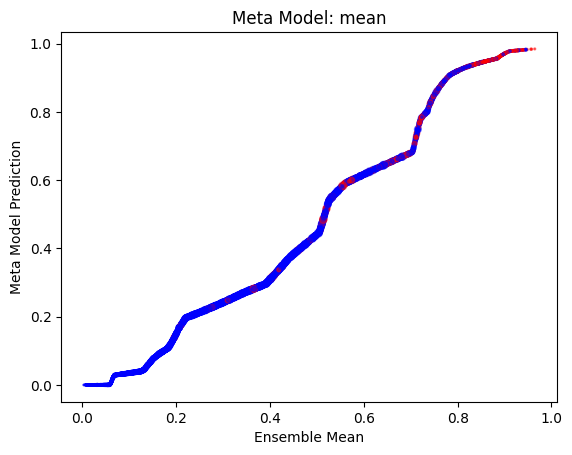

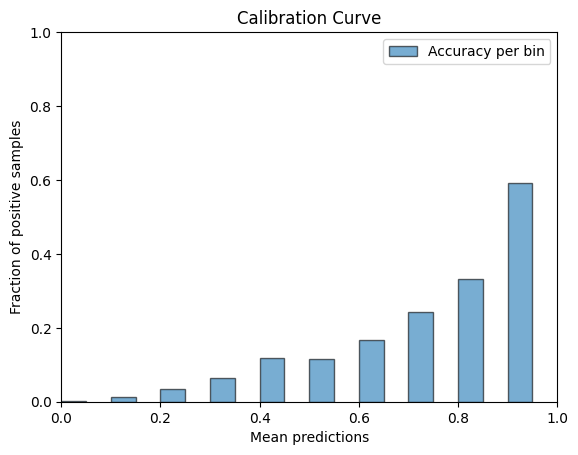

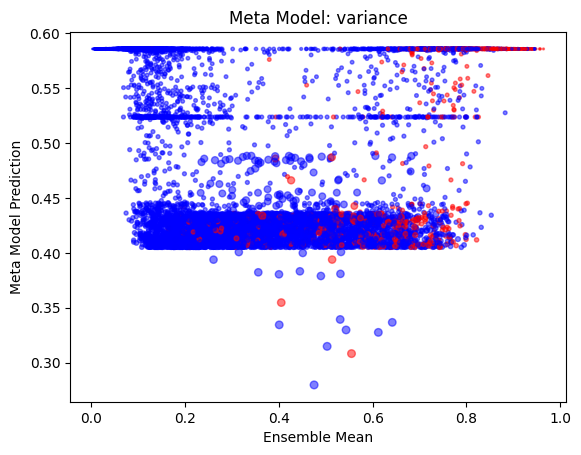

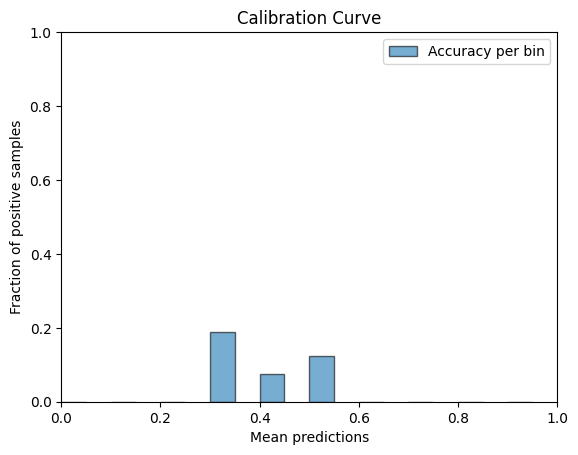

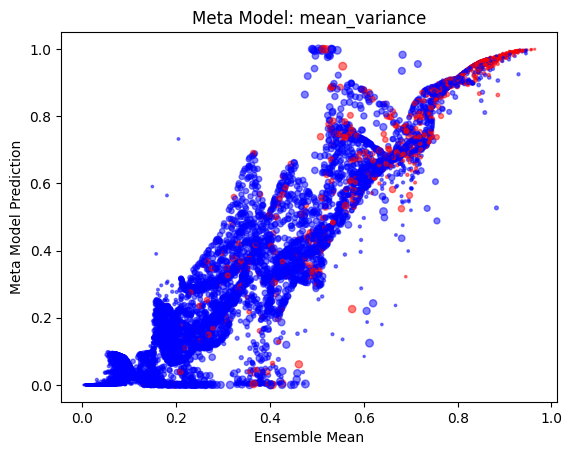

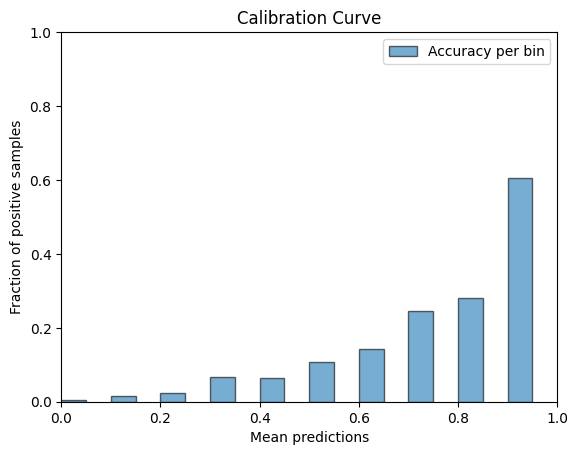

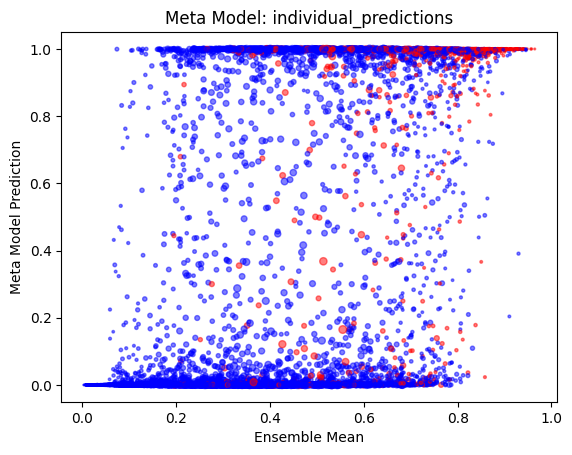

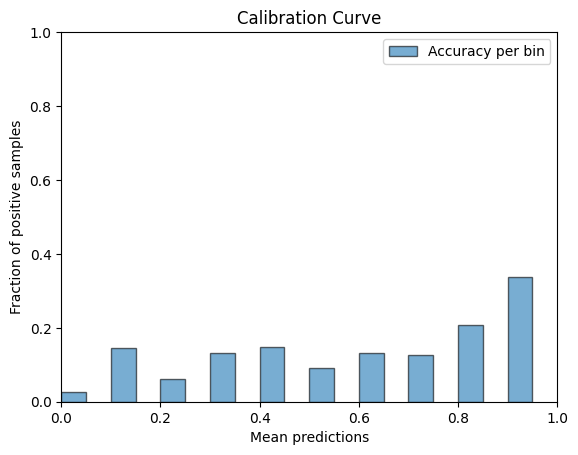

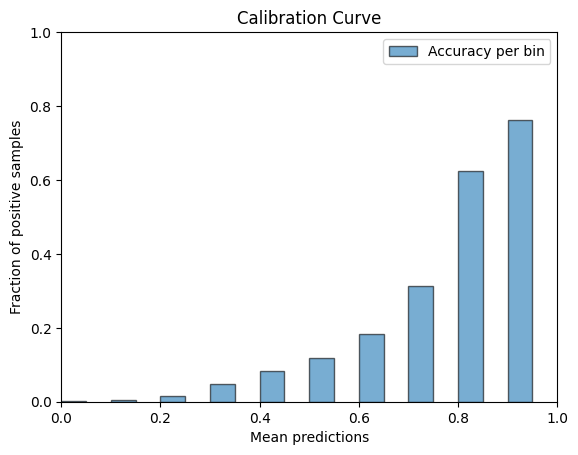

trained on val, tested on corrupted


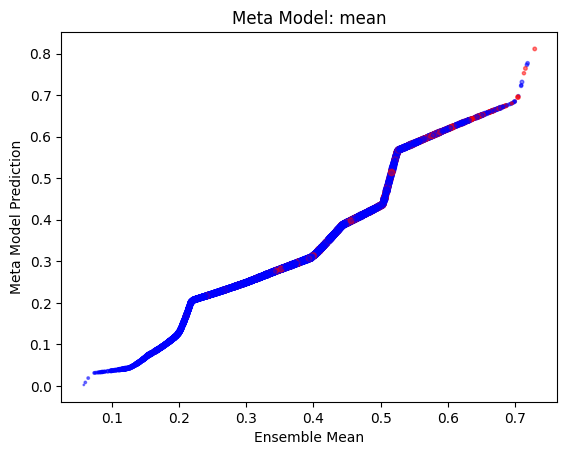

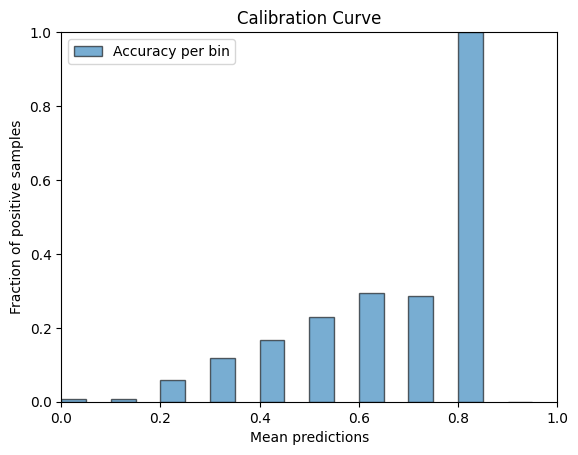

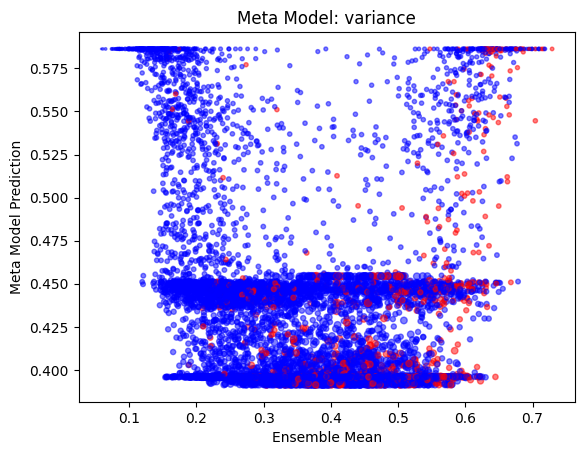

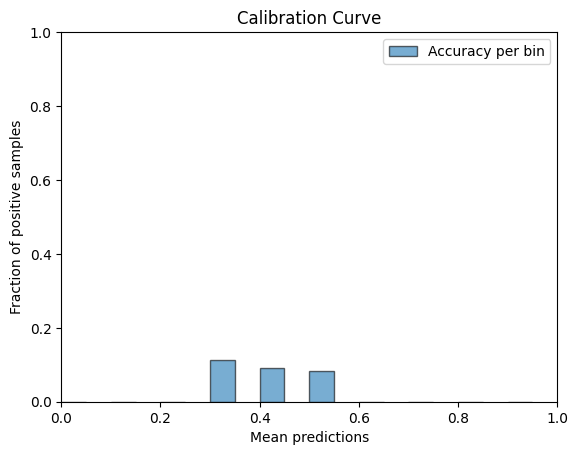

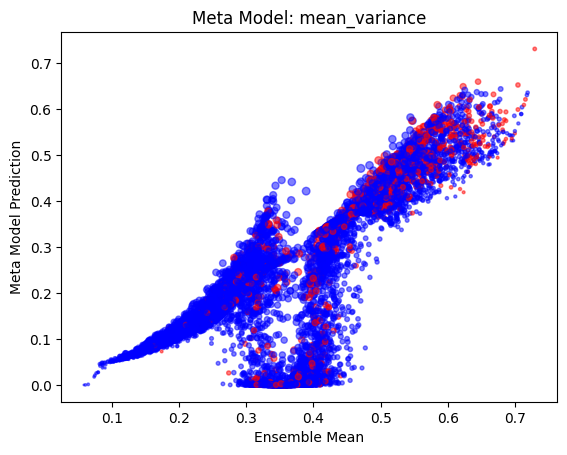

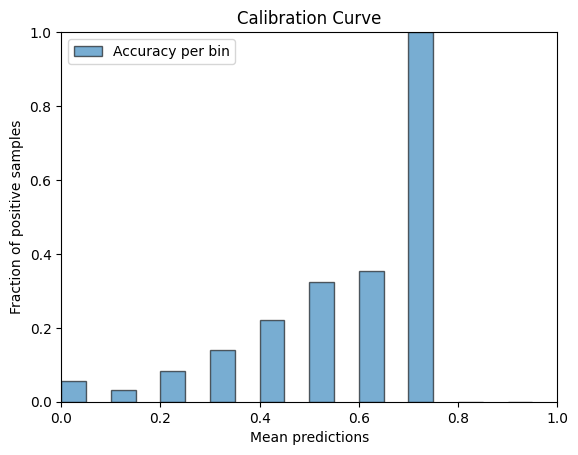

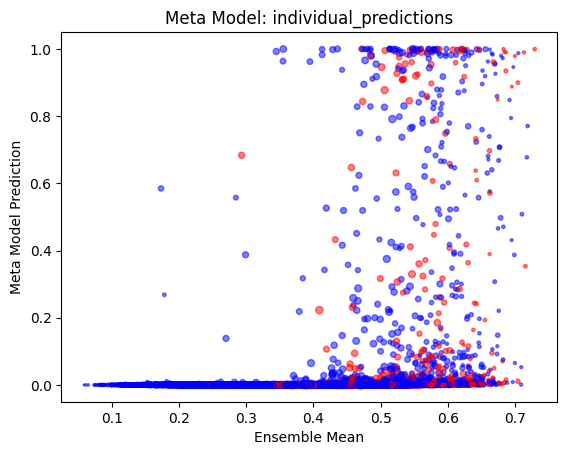

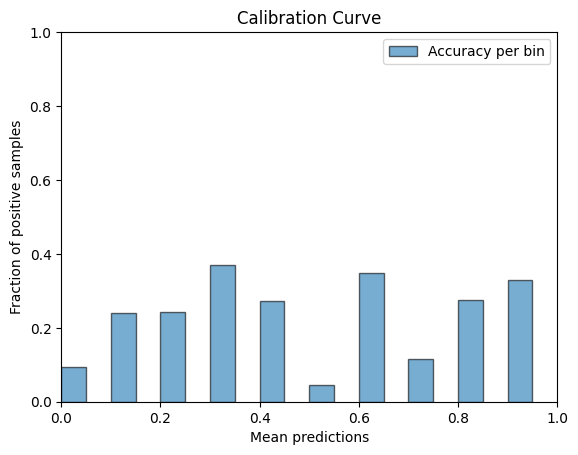

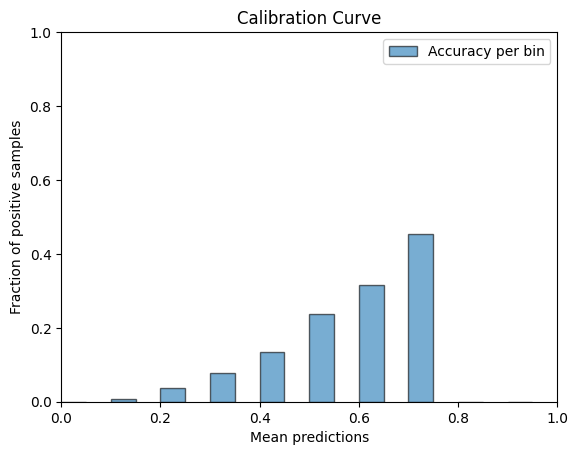

trained on val corrupted, tested on corrupted


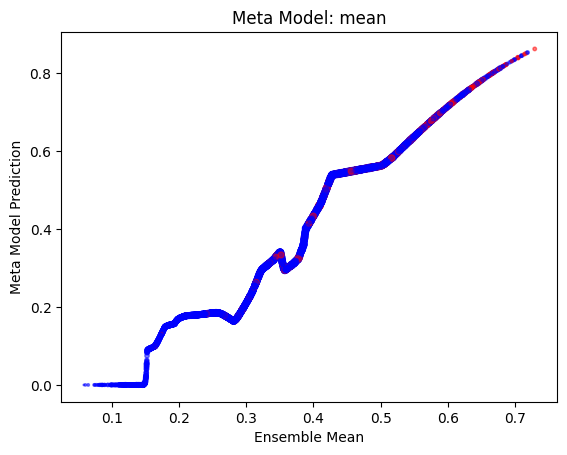

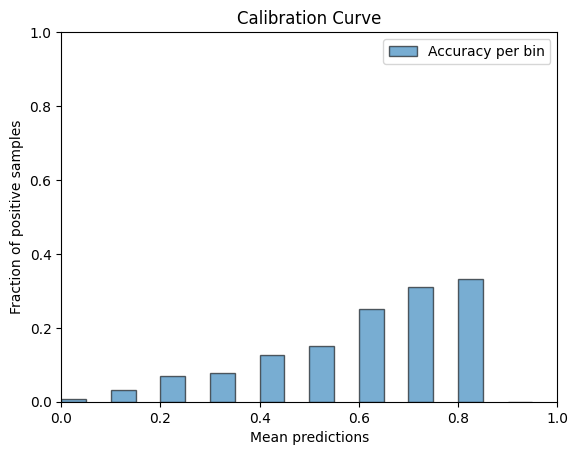

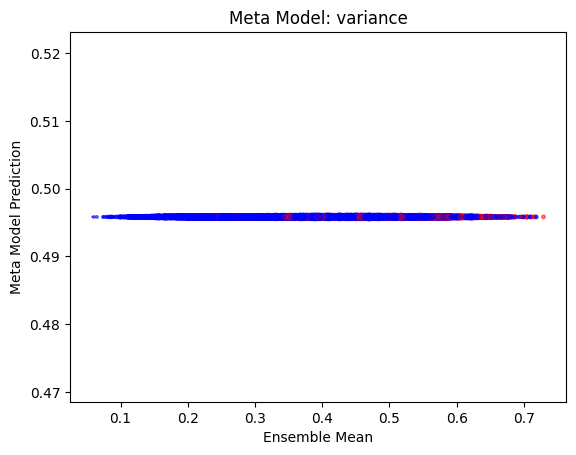

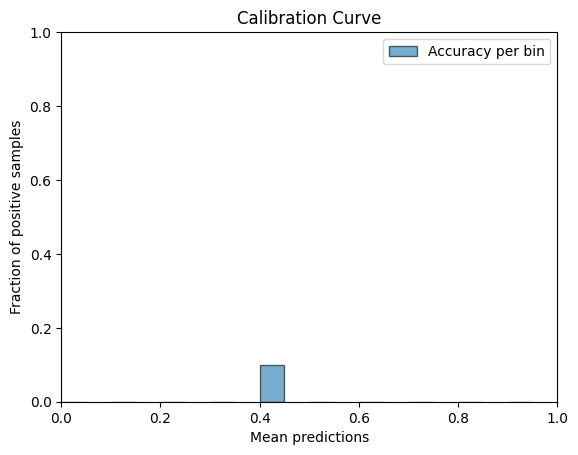

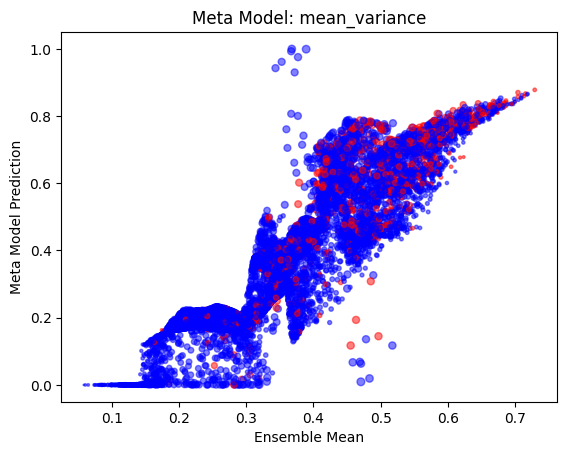

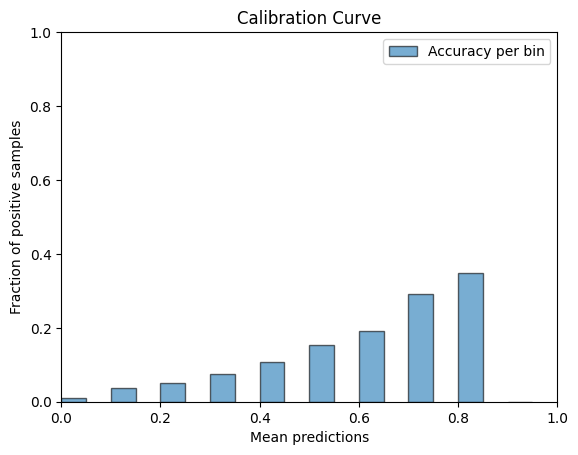

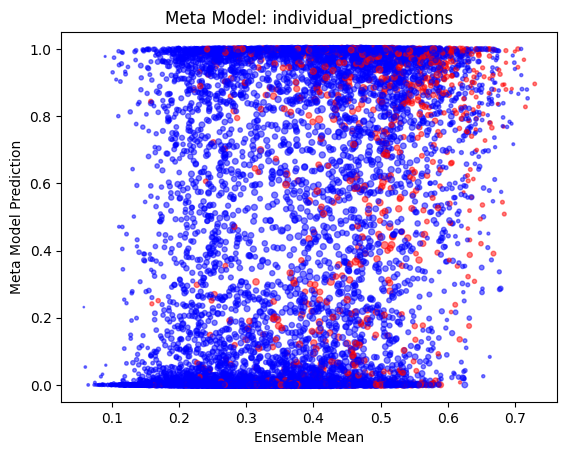

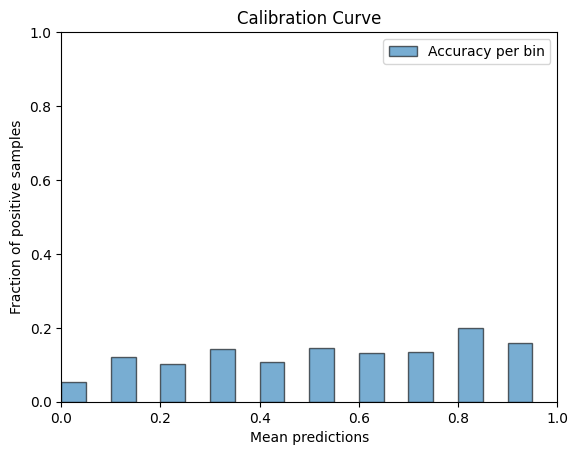

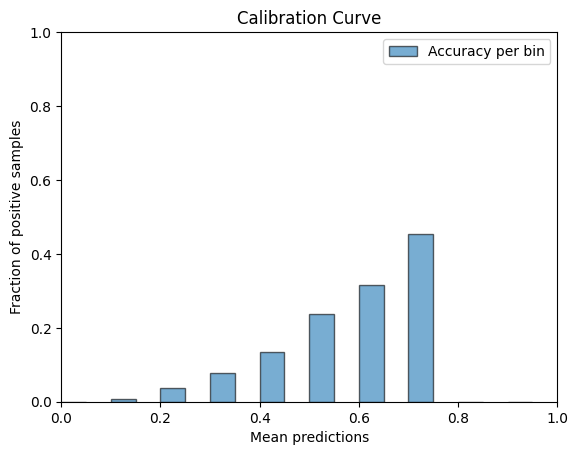

,title,auc,accuracy,precision,recall,f1_score,ece
0,Meta Model: mean,0.906313,0.789,0.304164,0.862,0.449661,0.206452
0,Meta Model: variance,0.587266,0.789,0.304164,0.862,0.449661,0.402937
0,Meta Model: mean_variance,0.897052,0.789,0.304164,0.862,0.449661,0.213541
0,Meta Model: individual_predictions,0.859618,0.789,0.304164,0.862,0.449661,0.184511
0,Base Model,0.906313,0.789,0.304164,0.862,0.449661,0.235944


,title,auc,accuracy,precision,recall,f1_score,ece
0,Meta Model: mean,0.746272,0.789,0.304164,0.862,0.449661,0.210508
0,Meta Model: variance,0.450708,0.789,0.304164,0.862,0.449661,0.334764
0,Meta Model: mean_variance,0.712784,0.789,0.304164,0.862,0.449661,0.130872
0,Meta Model: individual_predictions,0.639524,0.789,0.304164,0.862,0.449661,0.102924
0,Base Model,0.746272,0.820,0.255800,0.419,0.317665,0.257623


,title,auc,accuracy,precision,recall,f1_score,ece
0,Meta Model: mean,0.742387,0.789,0.304164,0.862,0.449661,0.253594
0,Meta Model: variance,0.500000,0.789,0.304164,0.862,0.449661,0.395823
0,Meta Model: mean_variance,0.746230,0.789,0.304164,0.862,0.449661,0.259790
0,Meta Model: individual_predictions,0.662103,0.789,0.304164,0.862,0.449661,0.318457
0,Base Model,0.746272,0.820,0.255800,0.419,0.317665,0.257623


In [66]:

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
# logistic regression
from sklearn.linear_model import LogisticRegression

# sequential model
from tensorflow.keras.models import Sequential

def compare_meta_models(train_df, test_df, title=''):
    result_dataframes = []

    for feature in ['mean', 'variance', 'mean_variance', 'individual_predictions', 'base_model']:
        if not feature == 'base_model':
            x_train, y_train = create_x_y(train_df, feature=feature)
            x_test, y_test = create_x_y(test_df, feature=feature)

            # Define the model
            model = Sequential()
            Input(shape=(x_train.shape[1],))
            model.add(Dense(32, activation='relu'))  # Input layer
            model.add(Dense(64, activation='relu'))  # Hidden layer
            model.add(Dense(128, activation='relu'))  # Hidden layer
            model.add(Dense(64, activation='relu'))  # Hidden layer
            model.add(Dense(32, activation='relu'))  # Hidden layer
            model.add(Dense(16, activation='relu'))  # Hidden layer
            model.add(Dense(1, activation='sigmoid'))  # Output layer

            # Compile the model
            model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

            # Fit the model
            early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
            model.fit(x_train, y_train, epochs=1000, batch_size=32, verbose=0)

            # Make predictions on the test set
            y_pred = model.predict(x_test, verbose=0)

            # make the size of points related to the normalized variance 
            normalized_variance = (test_df['variance'] - test_df['variance'].min()) / (test_df['variance'].max() - test_df['variance'].min())

            size_of_points = 30 * normalized_variance + 1

            # Make the colour of the points related to the label
            colour = np.where(test_df['label'] == 1, 'red', 'blue')


            # new figure
            plt.figure()
            plt.scatter(test_df['mean'], y_pred, s=size_of_points, c=colour, alpha=0.5)
            plt.xlabel('Ensemble Mean')
            plt.ylabel('Meta Model Prediction')
            plt.title(f'Meta Model: {feature}')
            plt.show()
            # Create a copy of df but replace the predictions with the meta model predictions
            df_test_meta = df_test.copy()
            df_test_meta['mean'] = y_pred
            # if mean is greater than 0.5 then the prediction is 1
            df_test_meta['prediction'] = np.where(df_test_meta['mean'] > 0.5, 1, 0)

            result_dataframes.append(evaluation_report(df_test_meta, f'{title} Meta Model: {feature}'));
        else:
            result_dataframes.append(evaluation_report(test_df, f'{title} Base Model'));

    return pd.concat(result_dataframes)


# Display the results
print('trained on val, tested on test')
result_df = compare_meta_models(df_val, df_test)
print('trained on val, tested on corrupted')
result_df_corrupted = compare_meta_models(df_val, df_corrupted,)
print('trained on val corrupted, tested on corrupted')
result_df_val_corrupted = compare_meta_models(df_val_corrupted, df_corrupted)
display(result_df)
display(result_df_corrupted)
display(result_df_val_corrupted)
    

